<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week5/Classification_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 5
# Classification

Classification is part of **supervised learning**. The objective is to correctly assign objects to different, predifined categories or labels. An easy to understand example is classifying emails as “spam” or “not spam.”

### Table of Contents
#### 0. Summary of some important concepts
#### 1. Basic Example
* 1.1 Create Data
* 1.2 Encoding of `Group`
* 1.3 Plot `x1` and `x2` according to `target`
* 1.4 Logistic Regression and Decision Boundary

#### 2. Predict Ad Click
* 2.1 Load and explore the dataset
* 2.2 Exploratory Data Analysis
* 2.3 Logistic Regression
* 2.4 Logistic Regression with standardization

#### 3. Multi Class Regression

## 0. Summary of some important concepts

Suppose you have a sample of 100 people, 20 of whom have purchased a certain product. You want to predict whether a person will `buy` (1) or `not buy` (0) the product based on her characteristics (e.g. male/female, age, etc.).

### A. Base rate
Represents the degree of accuracy you would obtain without using an algorithm (i.e. the prior probability of the most common class). In the example, p(`buy`) = 0.2 and p(`not buy`) = 0.8. This means that you would obtain an accuracy of 80% without using an algorithm if you classify each person as `not buy`. Clearly, our approach should outperform the base rate.

### B. Accuracy
This is the number of correct decisions for a model out of the total number of decisions. This should be greater than the base rate.

### C. True positive, true negative, false positive, false negative
* True positive: True label is positive (`buy`) and algorithm classifies as positive (`buy`).
* True negative: True label is negative (`not buy`) and algorithm classifies as negative (`not buy`).
* False positive: True label is negative (`not buy`), but algorithm classifies as positive (`buy`).
* False negative: True label is positive (`buy`), but algorithm classifies as negative (`not buy`).

We can summarize these concepts using the confusion matrix.



In [1]:
# Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline
sns.set_style("dark")

## 1. Basic Example

### 1.1 Create Data
For this example, we create data from scratch. We have a categorical variable (`Group`), two numerical variables (`x1` and `x2`) and the `target` is a binary variable. 

In [2]:
sample = [
    ["A", 0.1, 0.2, 0],
    ["A", 0.3, 0.05, 0],
    ["B", 0.3, 0.2, 0],
    ["D", 0.7, 0.65, 1],
    ["B", 0.25, 0.3, 0],
    ["A", 0.85, 0.55, 1],
    ["C", 0.1, 0.45, 0],
    ["C", 0.9, 0.85, 1],
    ["D", 0.95, 0.55, 1],
    ["B", 0.8, 0.8, 1]
]

df = pd.DataFrame(sample, columns=["Group", "x1", "x2", "target"])
df

,Group,x1,x2,target
0,A,0.10,0.20,0
1,A,0.30,0.05,0
2,B,0.30,0.20,0
3,D,0.70,0.65,1
4,B,0.25,0.30,0
5,A,0.85,0.55,1
6,C,0.10,0.45,0
7,C,0.90,0.85,1
8,D,0.95,0.55,1
9,B,0.80,0.80,1


### 1.2 Encoding of `Group`

We illustrate how to encode categorical features using:
* **One-hot encoding**: create a dummy variable for each category.
* **Label encoding**: assign integers to the different categories. Useful for ordered data.



In [3]:
# One-hot encoding
one_hot = OneHotEncoder()
cat_to_onehot = one_hot.fit_transform(df[["Group"]]).toarray()
cat_to_onehot = pd.DataFrame(cat_to_onehot, columns=one_hot.categories_)
cat_to_onehot

,A,B,C,D
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0


In [4]:
# Label encoding
le = LabelEncoder()
cat_to_label = pd.Series(le.fit_transform(df["Group"]))
cat_to_label

0    0
1    0
2    1
3    3
4    1
5    0
6    2
7    2
8    3
9    1
dtype: int32

In [5]:
le.classes_

array(['A', 'B', 'C', 'D'], dtype=object)

### 1.3 Plot `x1` and `x2` according to `target`
We are now interested in predicting `target` based on `x1` and `x2`. We first generate a plot.

<Axes: xlabel='x1', ylabel='x2'>

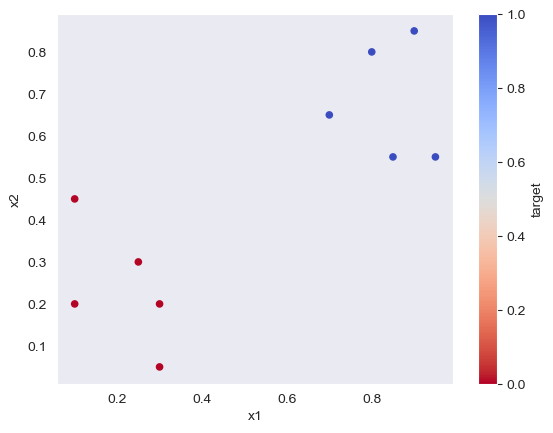

In [6]:
df.plot.scatter("x1", "x2", c="target", colormap="coolwarm_r")

We can see a clear separation. Points with low value of `x1` and `x2` are in the first class (`target` = 0) and points with high value of `x1` and `x2` are in the second class (`target` = 1). We can further compute the base rate (i.e the probability of the most common class).

In [7]:
# Base rate
max(len(df[df["target"] == 0]) / len(df), len(df[df["target"] == 1]) / len(df))

0.5

### 1.4 Logistic Regression and Decision Boundary
We now fit a logistic regression and generate a plot showing the decision boundary of the model.

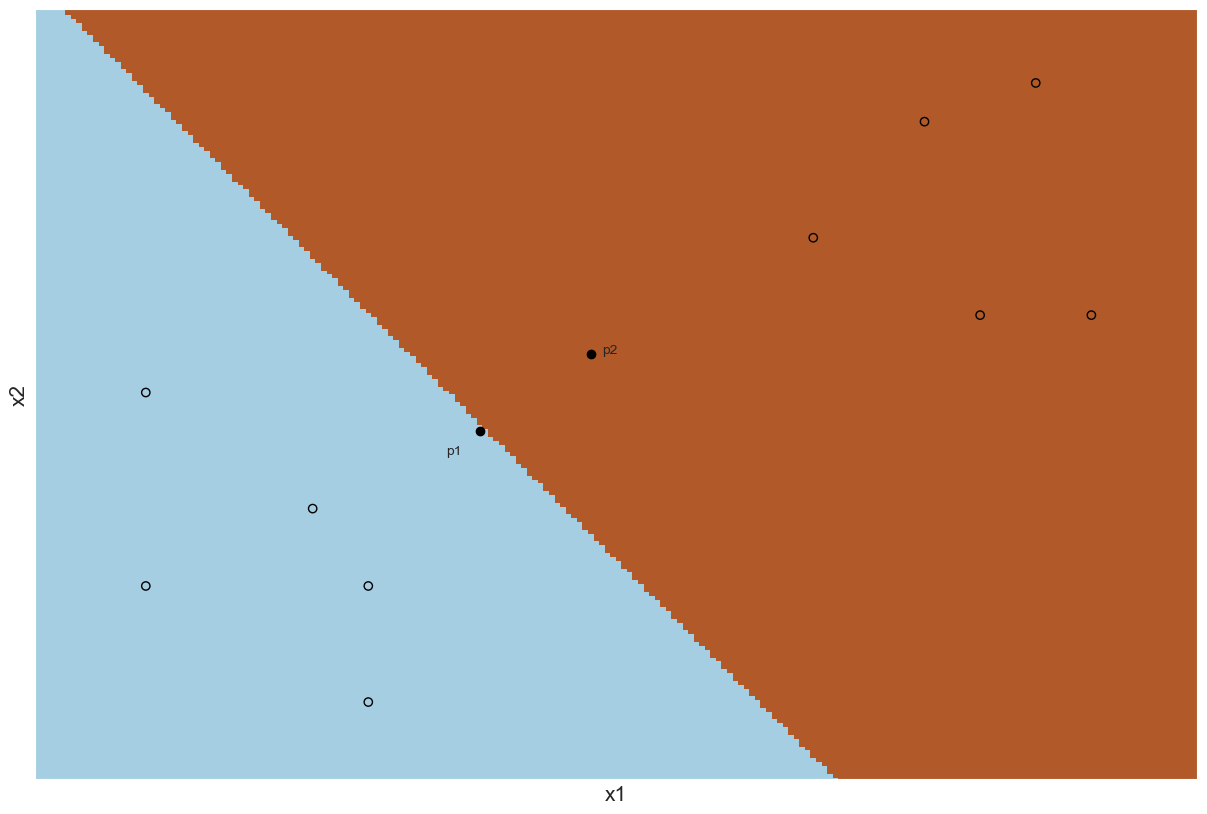

In [8]:
# Fit model
X = df[["x1", "x2"]].values
y = df["target"]
LR = LogisticRegressionCV()
LR.fit(X, y)

# Plot
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
h = .005  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = LR.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points and two new points (p1 and p2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(0.4, 0.4, c='black') # p1
plt.scatter(0.5, 0.5, c='black') # p2
plt.text(0.37, 0.37, 'p1')
plt.text(0.51, 0.5, 'p2')
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [9]:
# Prediction for p1 and p2
p = pd.DataFrame([[0.4, 0.4], 
                 [0.5, 0.5]], columns=["x1", "x2"])
LR.predict(p)

C:\Users\lucku\anaconda3\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


array([0, 1], dtype=int64)

In [10]:
# Score of the model --> better than base rate :)
LR.score(X, y)
# accuracy_score(LR.predict(X), y)

1.0

## 2. Predict Ad Click
In this section, we use **Logistic Regression** to predict whether or not a particular Internet user will click on an advertisement. You can find the data set [here](https://www.kaggle.com/fayomi/advertising).

### 2.1 Load and explore the dataset

In [11]:
data = pd.read_csv("https://raw.githubusercontent.com/LKunz/Projets/refs/heads/main/Data%20Science/data/advertising.csv")
data

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


The data set has 1000 rows and 10 features:

* `Daily Time Spent on Site`: consumer time on site in minutes
* `Age`: cutomer age in years
* `Area Income`: Avg. Income of geographical area of consumer
* `Daily Internet Usage`: Avg. minutes a day consumer is on the internet
* `Ad Topic Line`: Headline of the advertisement
* `City`: City of consumer
* `Male`: Whether or not consumer was male
* `Country`: Country of consumer
* `Timestamp`: Time at which consumer clicked on Ad or closed window
* `Clicked on Ad`: 0 or 1 indicated clicking on Ad

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [13]:
# Date format
data["Timestamp"] = pd.to_datetime(data["Timestamp"], format="%Y-%m-%d")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Daily Time Spent on Site  1000 non-null   float64       
 1   Age                       1000 non-null   int64         
 2   Area Income               1000 non-null   float64       
 3   Daily Internet Usage      1000 non-null   float64       
 4   Ad Topic Line             1000 non-null   object        
 5   City                      1000 non-null   object        
 6   Male                      1000 non-null   int64         
 7   Country                   1000 non-null   object        
 8   Timestamp                 1000 non-null   datetime64[ns]
 9   Clicked on Ad             1000 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 78.2+ KB


In [15]:
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


### 2.2 Exploratory Data Analysis

Text(0.5, 0, 'Age')

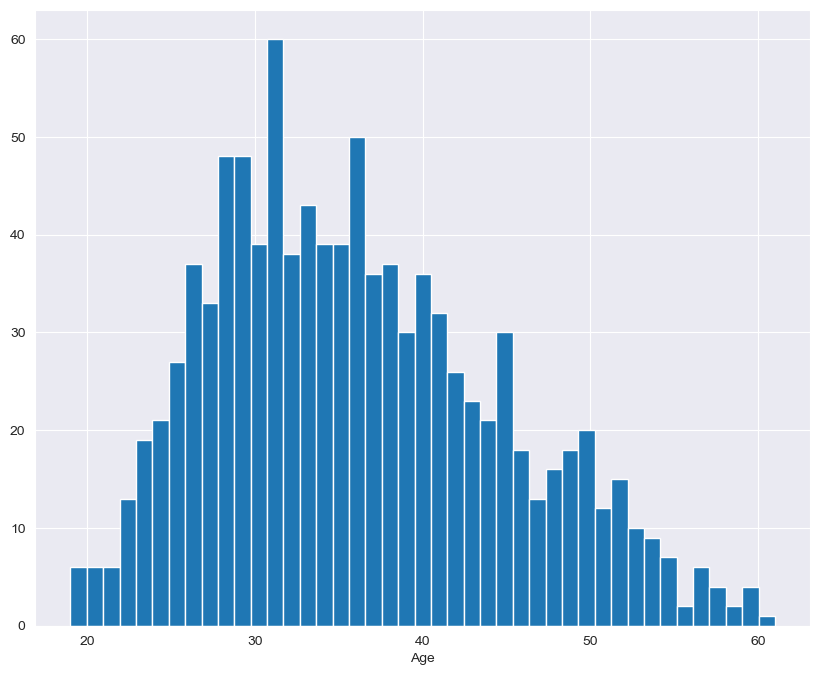

In [16]:
# Age repartition
plt.figure(figsize=(10, 8))
data.Age.hist(bins=data.Age.nunique())
plt.xlabel('Age')

Text(0.5, 0, 'Daily Time Spent on Site')

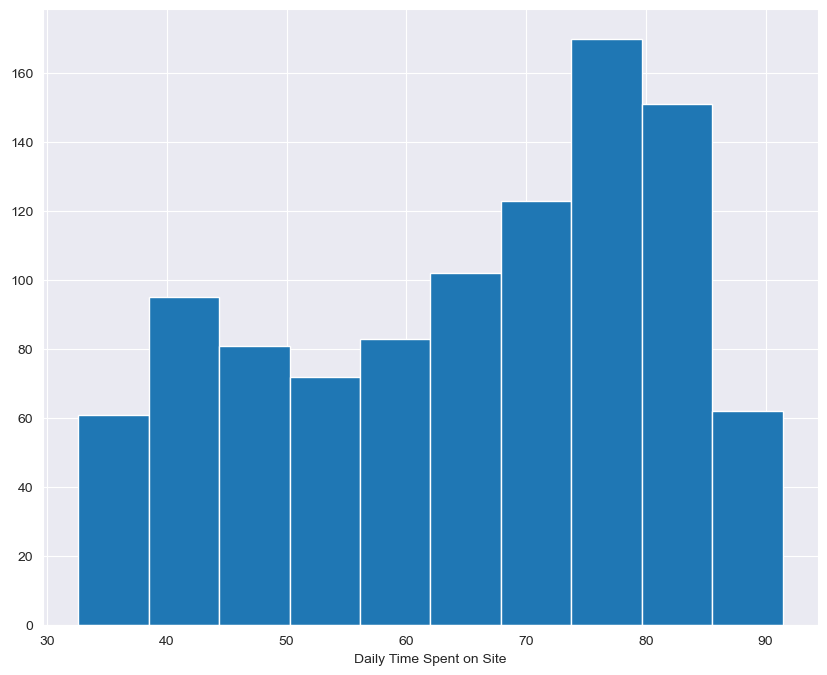

In [17]:
# Time on site
plt.figure(figsize=(10, 8))
data["Daily Time Spent on Site"].hist()
plt.xlabel("Daily Time Spent on Site")

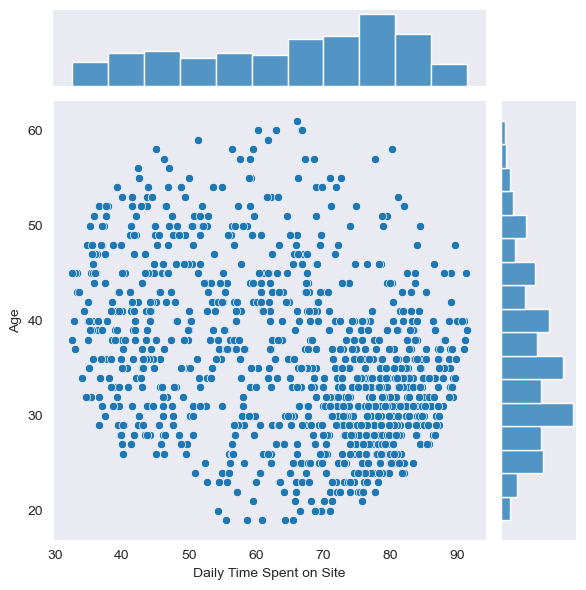

In [18]:
# Does younger people spend more time on site?
sns.jointplot(x="Daily Time Spent on Site", y="Age", data=data)

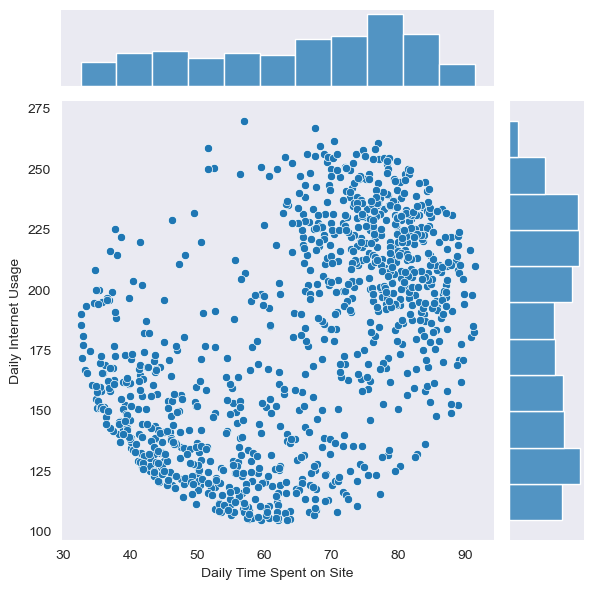

In [19]:
sns.jointplot(x=data["Daily Time Spent on Site"], y=data["Daily Internet Usage"], data=data)

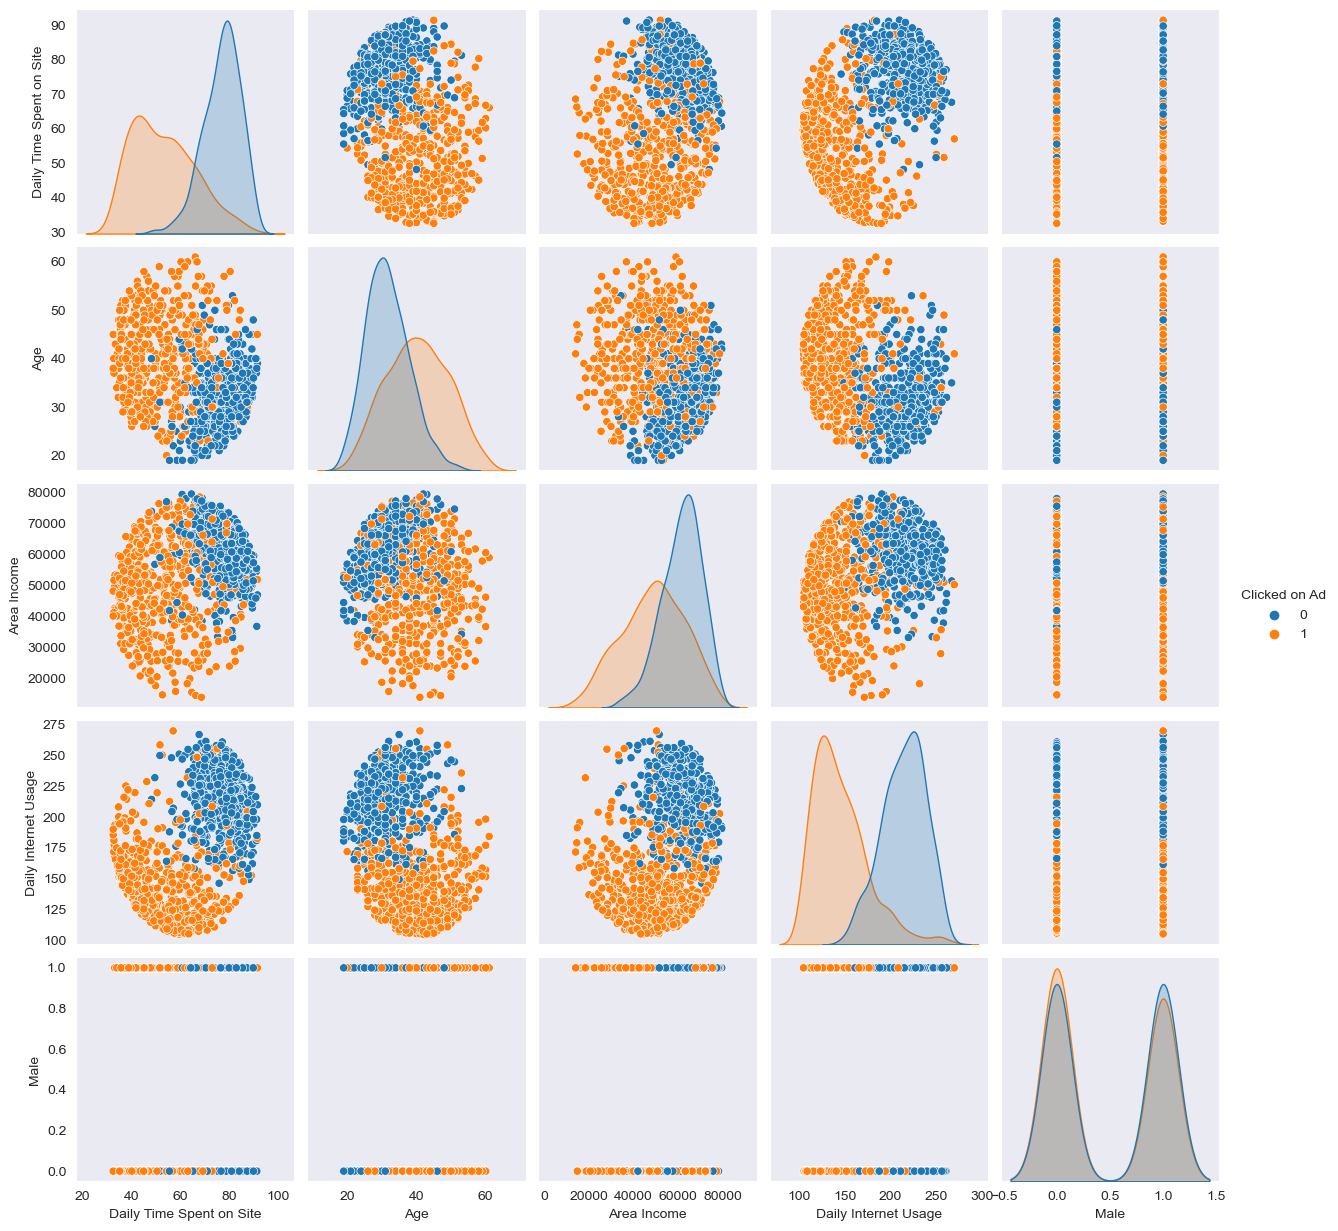

In [20]:
sns.pairplot(data, hue='Clicked on Ad')

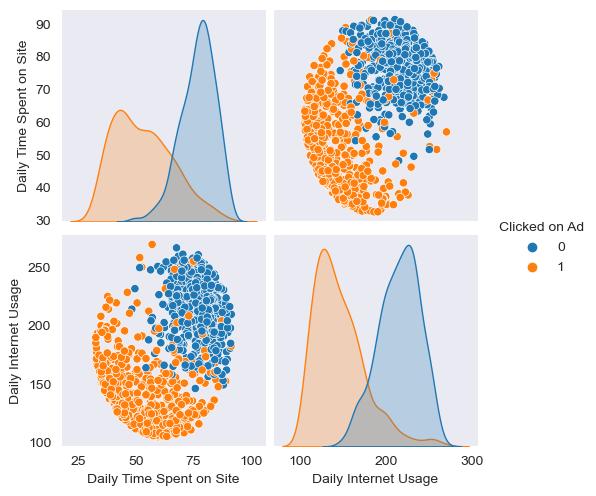

In [21]:
data2 = data[["Daily Time Spent on Site", "Daily Internet Usage", "Clicked on Ad"]]
sns.pairplot(data2, hue="Clicked on Ad")

### 2.3 Logistic Regression

Logistic regression is the classic linear classification algorithm for two-class problems.

#### 2.3.1 Theory

##### Logistic Regression

Logistic regression is named for the function used at the core of the method, the [logistic function](https://en.wikipedia.org/wiki/Logistic_function).

The logistic function, also called the **`Sigmoid function`** was developed by statisticians to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment. It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

$$\frac{1}{1 + e^{-x}}$$

$e$ is the base of the natural logarithms and $x$ is value that you want to transform via the logistic function.

Text(0.5, 1.0, 'Sigmoid Function')

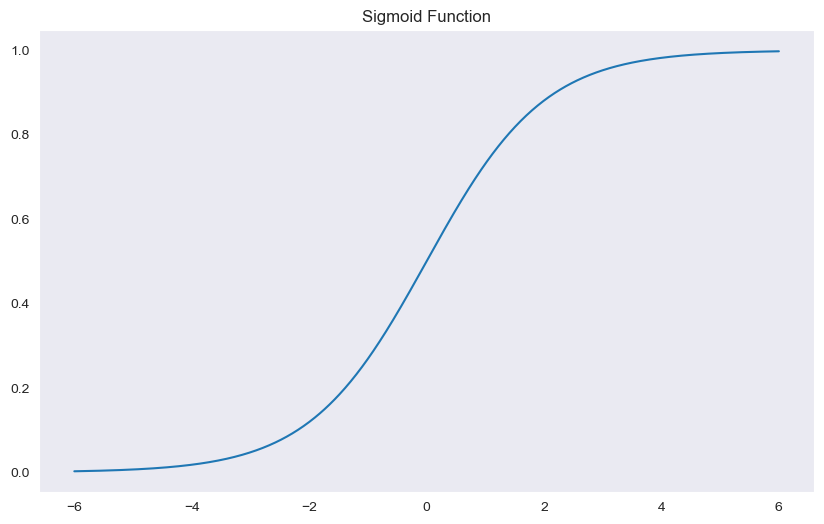

In [22]:
x = np.linspace(-6, 6, num=1000)
plt.figure(figsize=(10, 6))
plt.plot(x, (1 / (1 + np.exp(-x))))
plt.title("Sigmoid Function")

The logistic regression equation has a very similar representation like linear regression. The difference is that the output value being modelled is binary in nature.

$$\hat{y}=\frac{e^{\beta_0+\beta_1x_1}}{1+\beta_0+\beta_1x_1}$$

or

$$\hat{y}=\frac{1.0}{1.0+e^{-\beta_0-\beta_1x_1}}$$

$\beta_0$ is the intecept term

$\beta_1$ is the coefficient for $x_1$

$\hat{y}$ is the predicted output with real value between 0 and 1. To convert this to binary output of 0 or 1, this would either need to be rounded to an integer value or a cutoff point be provided to specify the class segregation point.
***
##### Learning the Logistic Regression Model

The coefficients (Beta values b) of the logistic regression algorithm must be estimated from your training data. This is done using [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

Maximum-likelihood estimation is a common learning algorithm used by a variety of machine learning algorithms, although it does make assumptions about the distribution of your data (more on this when we talk about preparing your data).

The best coefficients would result in a model that would predict a value very close to 1 (e.g. male) for the default class and a value very close to 0 (e.g. female) for the other class. The intuition for maximum-likelihood for logistic regression is that a search procedure seeks values for the coefficients (Beta values) that minimize the error in the probabilities predicted by the model to those in the data (e.g. probability of 1 if the data is the primary class).

We are not going to go into the math of maximum likelihood. It is enough to say that a minimization algorithm is used to optimize the best values for the coefficients for your training data. This is often implemented in practice using efficient numerical optimization algorithm (like the Quasi-newton method).

When you are learning logistic, you can implement it yourself from scratch using the much simpler gradient descent algorithm.

##### Prepare Data for Logistic Regression
The assumptions made by logistic regression about the distribution and relationships in your data are much the same as the assumptions made in linear regression.

Much study has gone into defining these assumptions and precise probabilistic and statistical language is used. My advice is to use these as guidelines or rules of thumb and experiment with different data preparation schemes.

Ultimately in predictive modeling machine learning projects you are laser focused on making accurate predictions rather than interpreting the results. As such, you can break some assumptions as long as the model is robust and performs well.

- **Binary Output Variable:** This might be obvious as we have already mentioned it, but logistic regression is intended for binary (two-class) classification problems. It will predict the probability of an instance belonging to the default class, which can be snapped into a 0 or 1 classification.
- **Remove Noise:** Logistic regression assumes no error in the output variable (y), consider removing outliers and possibly misclassified instances from your training data.
- **Gaussian Distribution:** Logistic regression is a linear algorithm (with a non-linear transform on output). It does assume a linear relationship between the input variables with the output. Data transforms of your input variables that better expose this linear relationship can result in a more accurate model. For example, you can use log, root, Box-Cox and other univariate transforms to better expose this relationship.
- **Remove Correlated Inputs:** Like linear regression, the model can overfit if you have multiple highly-correlated inputs. Consider calculating the pairwise correlations between all inputs and removing highly correlated inputs.
- **Fail to Converge:** It is possible for the expected likelihood estimation process that learns the coefficients to fail to converge. This can happen if there are many highly correlated inputs in your data or the data is very sparse (e.g. lots of zeros in your input data).

#### 2.3.2 Implementing Logistic Regression

In [23]:
# Base rate
data[data["Clicked on Ad"] == 0]
#max(len(data[data["Clicked on Ad"] == 0])/len(data), len(data[data["Clicked on Ad"] == 1])/len(data))

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
986,76.44,28,59967.19,232.68,Synchronized human-resource moderator,Port Julie,1,Northern Mariana Islands,2016-04-06 17:26:37,0
988,89.71,48,51501.38,204.40,Versatile local forecast,Sarafurt,1,Bahrain,2016-02-17 07:00:38,0
989,70.96,31,55187.85,256.40,Ameliorated user-facing help-desk,South Denise,0,Saint Pierre and Miquelon,2016-06-26 07:01:47,0
993,64.20,27,66200.96,227.63,Phased zero tolerance extranet,Edwardsmouth,1,Isle of Man,2016-02-11 23:45:01,0


In [24]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [25]:
# Encode Country and City
data["Country"] = data.Country.astype('category').cat.codes
data["City"] = data.City.astype('category').cat.codes
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,961,0,215,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,903,1,147,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,111,0,184,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,939,1,103,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,805,0,96,2016-06-03 03:36:18,0


In [26]:
# Select variables
X = data.drop(['Timestamp', 'Clicked on Ad', 'Ad Topic Line'], axis=1)
y = data['Clicked on Ad']
X

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country
0,68.95,35,61833.90,256.09,961,0,215
1,80.23,31,68441.85,193.77,903,1,147
2,69.47,26,59785.94,236.50,111,0,184
3,74.15,29,54806.18,245.89,939,1,103
4,68.37,35,73889.99,225.58,805,0,96
...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,126,1,116
996,51.30,45,67782.17,134.42,488,1,26
997,51.63,51,42415.72,120.37,798,1,140
998,55.55,19,41920.79,187.95,935,0,85


In [27]:
y

0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: Clicked on Ad, Length: 1000, dtype: int64

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country
29,76.02,22,46179.97,209.82,898,0,27
535,78.76,32,70012.83,208.02,187,1,227
695,73.49,38,67132.46,244.23,475,0,229
557,79.67,28,58576.12,226.79,77,0,46
836,49.21,46,49206.40,115.60,68,0,136
...,...,...,...,...,...,...,...
106,72.23,25,46557.92,241.03,435,1,24
270,44.49,53,63100.13,168.00,273,1,185
860,91.37,45,51920.49,182.65,416,1,108
435,56.66,42,72684.44,139.42,385,0,58


In [29]:
X_test

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country
521,63.26,29,54787.37,120.46,145,1,65
737,71.23,52,41521.28,122.59,198,0,203
740,43.63,38,61757.12,135.25,212,1,111
660,42.04,49,67323.00,182.11,485,0,171
411,78.68,29,66225.72,208.05,418,0,102
...,...,...,...,...,...,...,...
408,51.68,49,51067.54,258.62,328,0,67
332,56.30,49,67430.96,135.24,808,1,151
208,59.51,58,39132.64,140.83,626,0,12
613,76.21,31,65834.97,228.94,409,1,25


In [30]:
# Fit Model
log_reg = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1], dtype=int64)

In [31]:
y_test.values

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1], dtype=int64)

#### 2.3.3 Performance measurement

In [32]:
def evaluate(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [33]:
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[85  4]
 [12 99]]
ACCURACY SCORE:
0.9200
CLASSIFICATION REPORT:
	Precision: 0.9612
	Recall: 0.8919
	F1_Score: 0.9252


In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True positives: " + str(tp))
print("True negatives: " + str(tn))
print("False positives: " + str(fp))
print("False negatives: " + str(fn))

True positives: 99
True negatives: 85
False positives: 4
False negatives: 12


###### Confusion matrix:
* true positives (99): people who clicked on ad and were classified as clicked on ad.
* true negatives (85): people who did not click on ad and were classified as did not click on ad.
* false positives (4): people who did not click on as and were classified as clicked on as.
* false negatives (12): people who clicked on ad and were classified as did not click on ad.

###### Accuracy score:
correct classifications / total = (85+93) / (85+93+18+4) = 0.89

###### Precision:
true positives / (true positives + false positives) = 93 / (93+4) = 0.9588

###### Recall:
true positives / (true positives + false negatives) = 93 / (93+18) = 0.8378

###### F1 score:
harmonic mean of precision and recall.


### 2.4 Logistic Regression with standardization


Standardization is helpful to give the same weight (or importance) to each predictor variable. The aim is to resize the s so that their mean equal 0 and their standard deviation equal 1.

In [35]:
# Standardize features
standardize = StandardScaler()
standardize.fit(X_train, y_train)
# !!!IMPORTANT: we must fit on the training set, not on the whole set!!!

X_train_s = standardize.transform(X_train)
X_test_s = standardize.transform(X_test)

pd.DataFrame(X_train_s, columns=X_train.columns)#.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,City,Male,Country
0,0.681519,-1.591714,-0.663929,0.645655,1.472920,-0.955968,-1.248590
1,0.853777,-0.458721,1.117805,0.604556,-1.073962,1.046060,1.606513
2,0.522463,0.221075,0.902470,1.431327,-0.042314,-0.955968,1.635064
3,0.910987,-0.911918,0.262802,1.033125,-1.467994,-0.955968,-0.977355
4,-1.003970,1.127470,-0.437674,-1.505639,-1.500233,-0.955968,0.307441
...,...,...,...,...,...,...,...
795,0.443249,-1.251816,-0.635673,1.358262,-0.185598,1.046060,-1.291416
796,-1.300707,1.920566,0.601015,-0.309207,-0.765900,1.046060,1.006941
797,1.646541,1.014171,-0.234770,0.025291,-0.253658,1.046060,-0.092273
798,-0.535604,0.674273,1.317533,-0.961765,-0.364704,-0.955968,-0.806049


In [36]:
# Fit Logistic Regression and compute predictions
log_reg_s = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
log_reg_s.fit(X_train_s, y_train)
y_pred_s = log_reg_s.predict(X_test_s)

# Performance measurement
evaluate(y_test, y_pred_s)

CONFUSION MATRIX:
[[ 86   3]
 [  5 106]]
ACCURACY SCORE:
0.9600
CLASSIFICATION REPORT:
	Precision: 0.9725
	Recall: 0.9550
	F1_Score: 0.9636


## 3. Multi Class Regression
Let's now consider a classification problem with more than 2 target classes. For this we will use the iris data-set which has 3 target classes.

In [37]:
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features
y = iris.target
X[:10] # first 10 instances

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1]])

In [38]:
y # three classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [39]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [40]:
# Fit model
log_reg = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

In [41]:
# Accuracy of training set
log_reg.score(X_train, y_train)

0.8166666666666667

In [42]:
log_reg.score(X_test, y_test)
# accuracy_score(log_reg.predict(X_test), y_test)

0.8666666666666667

In [43]:
# True values
y_test

array([1, 1, 2, 0, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1,
       1, 1, 2, 0, 2, 1, 2, 0])

In [44]:
# Predictions
log_reg.predict(X_test)

array([2, 1, 2, 0, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 2, 2,
       2, 1, 2, 0, 2, 1, 2, 0])

In [45]:
log_reg.predict_proba(X_test)

array([[1.77960844e-02, 4.73752954e-01, 5.08450962e-01],
       [1.13122549e-02, 4.95681123e-01, 4.93006622e-01],
       [4.13765545e-03, 4.31665184e-01, 5.64197161e-01],
       [9.93604913e-01, 5.38507878e-03, 1.01000848e-03],
       [2.50467050e-01, 5.99690948e-01, 1.49842002e-01],
       [9.73861079e-01, 2.20646243e-02, 4.07429720e-03],
       [9.39099324e-01, 4.17332912e-02, 1.91673851e-02],
       [9.03841269e-01, 7.52317120e-02, 2.09270189e-02],
       [4.87463698e-02, 6.20214906e-01, 3.31038724e-01],
       [1.45996817e-06, 1.08727227e-01, 8.91271313e-01],
       [1.93657428e-02, 6.25791346e-01, 3.54842911e-01],
       [9.93124414e-01, 6.12482854e-03, 7.50757797e-04],
       [1.05682449e-04, 5.39188426e-02, 9.45975475e-01],
       [4.69199664e-02, 5.24620996e-01, 4.28459038e-01],
       [9.75430258e-01, 1.82065573e-02, 6.36318518e-03],
       [1.95037623e-02, 6.72310297e-01, 3.08185941e-01],
       [2.47529513e-02, 3.51816977e-01, 6.23430071e-01],
       [7.81628392e-01, 1.76262

In [46]:
# Create DateFrame with probabilities, predictions, and true classes in test set
iris_LR_summary = pd.DataFrame(np.round(log_reg.predict_proba(X_test), 2), columns=["p(0)", "p(1)", "p(2)"])
iris_LR_summary["Prediction"] = log_reg.predict(X_test)
iris_LR_summary["True Class"] = y_test
iris_LR_summary

,p(0),p(1),p(2),Prediction,True Class
0,0.02,0.47,0.51,2,1
1,0.01,0.50,0.49,1,1
2,0.00,0.43,0.56,2,2
3,0.99,0.01,0.00,0,0
4,0.25,0.60,0.15,1,1
5,0.97,0.02,0.00,0,0
6,0.94,0.04,0.02,0,0
7,0.90,0.08,0.02,0,0
8,0.05,0.62,0.33,1,1
9,0.00,0.11,0.89,2,2


In [47]:
# Confusion matrix - 4 errors out of 30 points
confusion_matrix(y_test, log_reg.predict(X_test))

array([[9, 0, 0],
       [0, 9, 4],
       [0, 0, 8]], dtype=int64)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

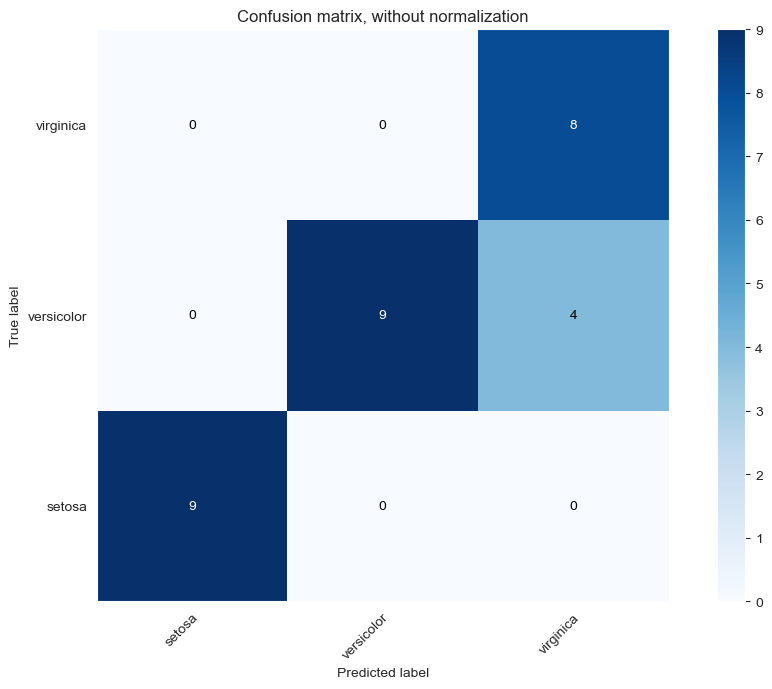

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(10,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.ylim([-0.5, 2.5])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, log_reg.predict(X_test), classes=iris.target_names,
                      title='Confusion matrix, without normalization')

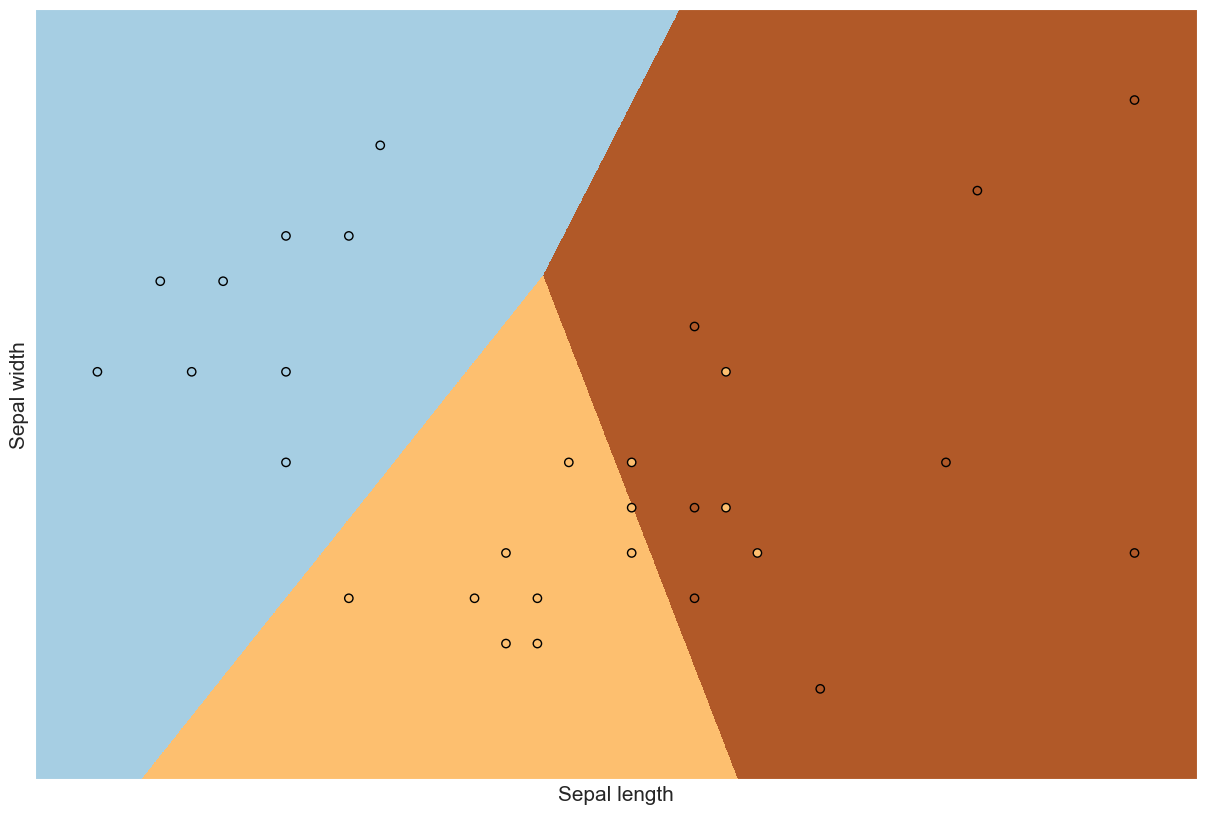

In [49]:
# Plot the decision boundaries for test set. For that, we will assign a 
# color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test[:, 0].min() - .2, X_test[:, 0].max() + .2
y_min, y_max = X_test[:, 1].min() - .2, X_test[:, 1].max() + .2
h = .001  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length', fontsize=15)
plt.ylabel('Sepal width', fontsize=15)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

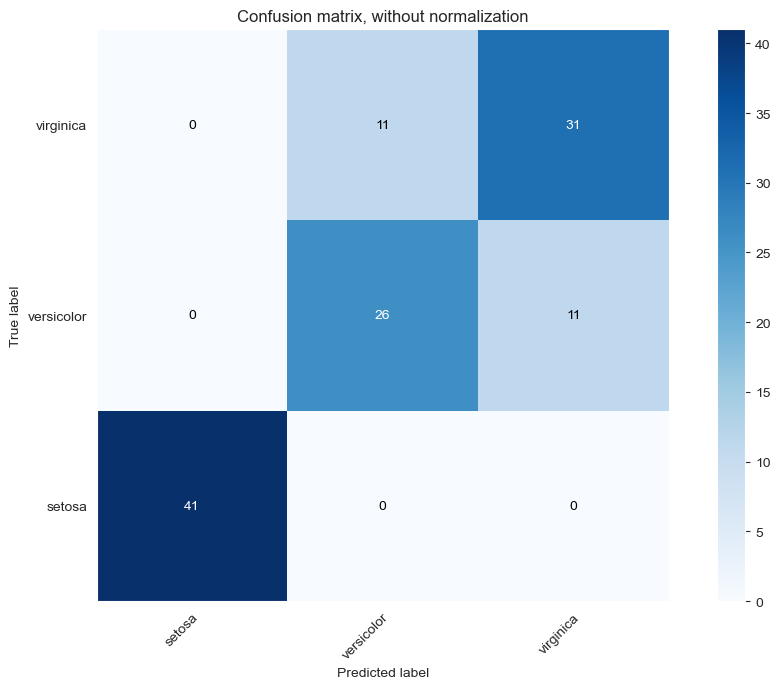

In [50]:
# confusion matrix - training set

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, log_reg.predict(X_train), classes=iris.target_names,
                      title='Confusion matrix, without normalization')

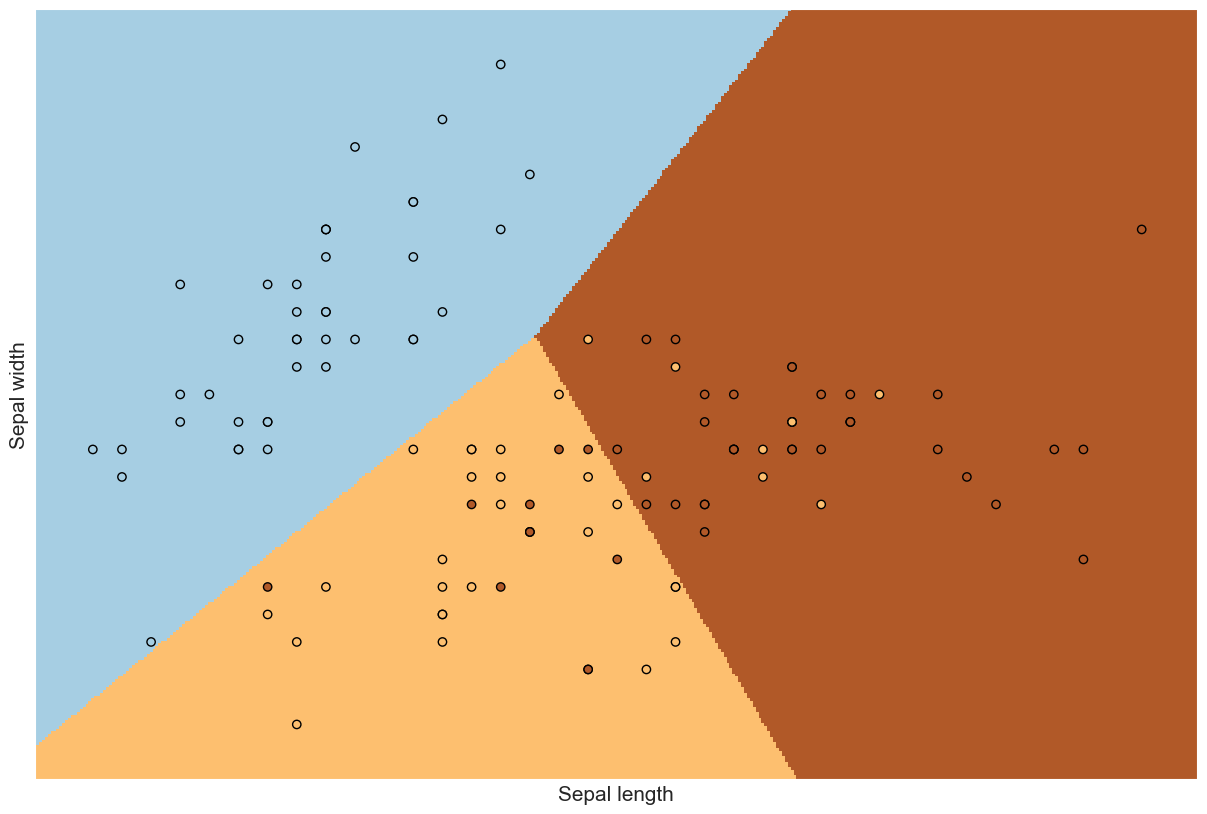

In [51]:
# Plot the decision boundaries for training set. For that, we will assign a 
# color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - .2, X_train[:, 0].max() + .2
y_min, y_max = X_train[:, 1].min() - .2, X_train[:, 1].max() + .2
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length', fontsize=15)
plt.ylabel('Sepal width', fontsize=15)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

## References:
* [Scikit Learn Library](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
* [Logistic Regression for Machine Learning by Jason Brownlee PhD](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)
* [Advertising - Logistic Regression](https://www.kaggle.com/arpitsomani/advertisement-logistic-regression#Predictions-and-Evaluations)